In [1]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README

--2020-03-26 11:01:17--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
ai.stanford.edu (ai.stanford.edu) をDNSに問いあわせています... 171.64.68.10
ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 84125825 (80M) [application/x-gzip]
`aclImdb_v1.tar.gz' に保存中

aclImdb_v1.tar.gz   100%[===================>]  80.23M  17.8MB/s 時間 6.6s       

2020-03-26 11:01:24 (12.1 MB/s) - `aclImdb_v1.tar.gz' へ保存完了 [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unl

In [2]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


In [7]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


## 【問題1】BoWのスクラッチ実装

In [37]:
import re
from collections import defaultdict

def my_bow(corpus, size=2):
    df = pd.DataFrame()
    for m, text in enumerate(corpus):
        count_dict = defaultdict(int)
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text).split(' ')
        for i in range(len(text)-size+1):
            n_gram = ' '.join(text[i:i+size])
            count_dict[n_gram] += 1
        df = pd.concat([df, pd.DataFrame(count_dict, index=[m])])
    df[df.isnull()] = 0
    return df.astype(int)     

In [38]:
my_bow(mini_dataset, 1)

,this,movie,is,very,good,film,a,bad
0,1,1,1,1,1,0,0,0
1,1,0,1,0,1,1,1,0
2,0,0,0,3,0,0,0,2


In [39]:
my_bow(mini_dataset, 2)

,this movie,movie is,is very,very good,this film,film is,is a,a good,very bad,bad very,very very
0,1,1,1,1,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,1,0,0,0
2,0,0,0,0,0,0,0,0,2,1,1


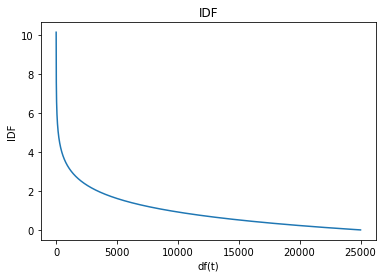

In [36]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

## 【問題2】TF-IDFの計算

In [40]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


In [41]:
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nambayasumasa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


## 【問題3】TF-IDFを用いた学習

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [49]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000,
                             norm=None)
train_vec = vectorizer.fit_transform(x_train)
test_vec = vectorizer.transform(x_test)

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(max_iter=25000)
lr.fit(train_vec, y_train)
y_pred = lr.predict(test_vec)
accuracy_score(y_test, y_pred)

0.80648

## 【問題4】TF-IDFのスクラッチ実装

In [111]:
def my_tfidf(corpus, version=1):
    df = pd.DataFrame()
    sample_num = len(corpus)
    
    for m, text in enumerate(corpus):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text.strip()).split(' ')
        words, counts = np.unique(text, return_counts=True)
        
        tfidf_dict = {}
        word_count = defaultdict(int)
        for word, count in zip(words, counts):
            if word != '':
                word_count[word] = count
        all_count = np.sum(list(word_count.values()))
        for word, count in word_count.items():
            if version == 1:
                tf = count / all_count
                idf = sample_num / np.sum([word in t.lower() for t in corpus])
            elif version == 2:
                tf = count
                idf = np.log((1+all_count)/(1+np.sum([word in t.lower() for t in corpus]))) + 1
            else:
                return None
            tfidf_dict[word] = tf * idf
        df = pd.concat([df, pd.DataFrame(tfidf_dict, index=[m])])
    df[df.isnull()] = 0
    return df

In [112]:
my_corpus = ['This movie is SOOOO funny!!!',
             'What a movie! I never',
             'best movie ever!!!!!! this movie'
            ]

my_tfidf(my_corpus, version=1)

,funny,is,movie,soooo,this,a,i,never,what,best,ever
0,0.6,0.3,0.2,0.6,0.3,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.2,0.0,0.0,0.6,0.2,0.6,0.6,0.0,0.0
2,0.0,0.0,0.4,0.0,0.3,0.0,0.0,0.0,0.0,0.6,0.3


In [113]:
my_tfidf(my_corpus, version=2)

,funny,is,movie,soooo,this,a,i,never,what,best,ever
0,2.098612,1.693147,1.405465,2.098612,1.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,1.405465,0.000000,0.000000,2.098612,1.405465,2.098612,2.098612,0.000000,0.000000
2,0.000000,0.000000,2.810930,0.000000,1.693147,0.000000,0.000000,0.000000,0.000000,2.098612,1.693147


In [104]:
from gensim.models import Word2Vec

sentences = [['this', 'movie', 'is', 'very', 'good'], 
             ['this', 'film', 'is', 'a', 'good'], 
             ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習
print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[ 0.01313935  0.03820832  0.0114129   0.01845999 -0.04945384  0.01938098
 -0.00854781 -0.01439927  0.00025507 -0.01320013]
movieのベクトル : 
[ 0.0177484   0.00711906  0.01342954  0.04532134 -0.01605103 -0.00132355
 -0.00945178  0.04911621  0.04281643  0.01613648]
isのベクトル : 
[-0.01677678  0.00059583 -0.01415623  0.01769616 -0.04380463  0.0130206
  0.04110475  0.00420902 -0.04153634 -0.01454718]
veryのベクトル : 
[ 0.04472078  0.02561098 -0.01938001  0.02518251  0.03740028  0.02780847
 -0.04379798 -0.01486497 -0.02207693 -0.04569792]
goodのベクトル : 
[-0.04218201  0.02438303 -0.00798141  0.00493966 -0.03495101  0.01487694
  0.0402325   0.01776426  0.0145033  -0.01711986]
filmのベクトル : 
[ 0.04072414 -0.02838983  0.02014256  0.02207327  0.02031376 -0.03418437
  0.0097797   0.02149761  0.01279733  0.02168466]
aのベクトル : 
[ 0.03935433  0.01963281 -0.00871215 -0.02140462  0.00938391 -0.03234237
  0.02321775  0.03354346

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [105]:
model.wv.most_similar(positive="good", topn=3)

[('is', 0.6251358985900879),
 ('this', 0.346548467874527),
 ('movie', 0.13377797603607178)]

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


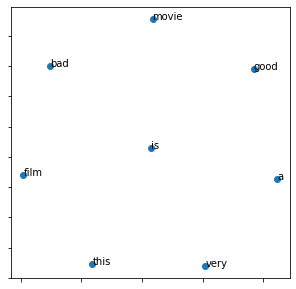

In [106]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

## 【問題5】コーパスの前処理

In [114]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_hashtag(text):
    html = re.compile(r'#\w+')
    return html.sub(r'', text)

def cleaning(corpus):
    cleaned = []
    for text in corpus:
        text = text.lower()
        text = remove_URL(text)
        text = remove_hashtag(text)
        text = re.sub(r'[^\w\s]', '', text.strip()).split(' ')
        cleaned.append(text)
    return cleaned

## 【問題6】Word2Vecの学習

In [116]:
cleaned_x_train = cleaning(x_train)
cleaned_x_test = cleaning(x_test)

In [120]:
model = Word2Vec(min_count=1, size=50)
model.build_vocab(cleaned_x_train) 
model.train(cleaned_x_train, total_examples=model.corpus_count, epochs=model.iter) # 学習
print("語彙の一覧 : {}".format(list(model.wv.vocab.keys())[:5]))
for vocab in list(model.wv.vocab.keys())[:5]:
    print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

/Users/nambayasumasa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


語彙の一覧 : ['zero', 'day', 'leads', 'you', 'to']
zeroのベクトル : 
[ 0.6342316   1.9376184  -1.4125903  -1.2854847  -0.6841922  -0.11913227
  0.9666363   0.2973788   0.5222077  -0.11954936  0.38307157  1.9057741
  0.59114486  0.08427388 -0.46176094  0.8061007  -0.24295764  1.2436292
  0.33814493  0.46138632 -0.15051492 -0.14225066  0.7521873   0.33858833
  1.4949274  -0.03634263 -1.5624084   0.1600785   0.7511265   1.328168
  2.037358    0.12894525  1.0383826   1.1808094  -1.1019338   0.14211851
  1.0543358  -1.1447315   0.22600111  0.5406074  -0.49594066 -0.31282985
  1.1277304  -0.49918616  0.9837932   0.35109082 -0.07052667  0.8376102
 -1.4778173   0.83772624]
dayのベクトル : 
[ 0.49595392 -0.16935179 -0.7970221   3.963907    1.0738497   1.4817339
 -0.8947953   1.8982569   2.3244052   1.9857354  -0.34646875  2.359755
 -3.9409928   0.82529956  0.8720695  -1.3730096   0.17116372 -0.89448565
  0.39773095 -2.472306   -0.01115894 -2.8867385   1.7885257   0.12259286
 -0.16470188  1.6555088  -1.2989821